# Tuning hyper parameters & evaluating the model

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Extracting data, preprocess and generating features

In [3]:
from demand_forecasting.read import read_data

# reading voiholm rode data 
rides_raw_df = read_data('../input/voiholm.csv')

# reading weather data
weather_raw_df = read_data('../input/weather_data.csv')

INFO:root:Read dataframe from file path ../input/voiholm.csv
INFO:root:Read dataframe from file path ../input/weather_data.csv


In [4]:
from demand_forecasting.verify import verify_ride_df, verify_weather_df

# verifying the dataframes 
rides_df = verify_ride_df(rides_raw_df)
weather_df = verify_weather_df(weather_raw_df)

INFO:root:Validated Voiholm ride dataframe
INFO:root:Validated weather dataframe


In [5]:
from demand_forecasting.preprocess import preprocessing

df = preprocessing(rides_df=rides_df, weather_df=weather_df)
df

INFO:root:Preprossed dataframe


,h3index_small,start_date,num_of_rides,date,temperature,max_temperature,min_temperature,precipitation,start_weekday
0,891f2506107ffff,2020-08-01,0.0,2020-08-01,17.6,19.3,15.6,0.69,Saturday
1,891f2506107ffff,2020-08-02,0.0,2020-08-02,16.7,19.1,14.8,0.00,Sunday
2,891f2506107ffff,2020-08-03,1.0,2020-08-03,16.8,19.6,14.3,0.00,Monday
3,891f2506107ffff,2020-08-04,2.0,2020-08-04,15.0,17.1,12.8,11.44,Tuesday
4,891f2506107ffff,2020-08-05,2.0,2020-08-05,21.5,26.5,17.0,0.50,Wednesday
...,...,...,...,...,...,...,...,...,...
9775,891f25a9ecbffff,2020-08-26,0.0,2020-08-26,16.7,20.8,13.5,0.00,Wednesday
9776,891f25a9ecbffff,2020-08-27,0.0,2020-08-27,13.9,18.5,9.1,0.60,Thursday
9777,891f25a9ecbffff,2020-08-28,0.0,2020-08-28,14.5,17.8,12.1,0.10,Friday
9778,891f25a9ecbffff,2020-08-29,1.0,2020-08-29,14.7,19.8,8.9,0.00,Saturday


In [6]:
from demand_forecasting.preprocess import extract_all_unique_h3index_small_areas
unique_h3index_df = extract_all_unique_h3index_small_areas(rides_df)
unique_h3index_df

,h3index_small
0,891f2506107ffff
1,891f2506123ffff
2,891f2506127ffff
3,891f250612bffff
4,891f250612fffff
...,...
321,891f25a9eafffff
322,891f25a9eb3ffff
323,891f25a9eb7ffff
324,891f25a9ebbffff


In [7]:
from demand_forecasting.features import generate_features_for_training

df_with_features = generate_features_for_training(df)
df_with_features

INFO:root:Generated features for training dataset


,h3index_small,start_date,num_of_rides,date,temperature,max_temperature,min_temperature,precipitation,start_weekday,avg_num_rides_in_area_one_week_before
0,891f2506107ffff,2020-08-01,0.0,2020-08-01,17.6,19.3,15.6,0.69,Saturday,NaN
1,891f2506107ffff,2020-08-02,0.0,2020-08-02,16.7,19.1,14.8,0.00,Sunday,NaN
2,891f2506107ffff,2020-08-03,1.0,2020-08-03,16.8,19.6,14.3,0.00,Monday,NaN
3,891f2506107ffff,2020-08-04,2.0,2020-08-04,15.0,17.1,12.8,11.44,Tuesday,NaN
4,891f2506107ffff,2020-08-05,2.0,2020-08-05,21.5,26.5,17.0,0.50,Wednesday,NaN
...,...,...,...,...,...,...,...,...,...,...
9775,891f25a9ecbffff,2020-08-26,0.0,2020-08-26,16.7,20.8,13.5,0.00,Wednesday,0.285714
9776,891f25a9ecbffff,2020-08-27,0.0,2020-08-27,13.9,18.5,9.1,0.60,Thursday,0.285714
9777,891f25a9ecbffff,2020-08-28,0.0,2020-08-28,14.5,17.8,12.1,0.10,Friday,0.285714
9778,891f25a9ecbffff,2020-08-29,1.0,2020-08-29,14.7,19.8,8.9,0.00,Saturday,0.142857


### Hyper parameter tuning 

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [9]:
from app import config

target_variable = config.MODEL_CONFIG['target']
features = config.MODEL_CONFIG['features']
features

['precipitation',
 'start_weekday',
 'max_temperature',
 'avg_num_rides_in_area_one_week_before']

In [10]:
# Creating X, y for train and evaluation 
all_feature_df = df_with_features[df_with_features.avg_num_rides_in_area_one_week_before.notna()]

columns = features.copy()
columns.append(target_variable)
model_df = all_feature_df[columns].copy()

model_df['start_weekday'] = model_df.start_weekday.astype("category")

# Setting a side evaluation data to not be used when training and hyper parameter tuning the model
training_df, evaluation_df = train_test_split(model_df, test_size=0.15, random_state=43)

X = training_df.drop(columns=target_variable)
y = training_df[[target_variable]]
X

,precipitation,start_weekday,max_temperature,avg_num_rides_in_area_one_week_before
9351,0.20,Saturday,20.5,2.285714
6479,0.00,Sunday,19.0,0.142857
3651,0.20,Saturday,20.5,6.428571
2358,1.19,Wednesday,24.3,14.428571
885,0.00,Sunday,30.6,9.000000
...,...,...,...,...
8092,0.00,Sunday,18.6,2.714286
3039,0.00,Monday,26.3,9.428571
3010,0.00,Tuesday,26.1,6.428571
4428,1.19,Wednesday,24.3,5.571429


In [11]:
# Deciding which hyperparameters to tune
max_depths = [2, 3, 4, 5, 6]
learning_rates = [0.01, 0.05, 0.10, 0.15]
n_estimators = [50, 100, 200, 300, 400]

result = []
for max_depth in max_depths: 
    for learning_rate in learning_rates:
        for n_estimator in n_estimators:
            # Defining the model
            xgb_model = xgb.XGBRegressor(enable_categorical=True,
                                         max_depth=max_depth,
                                         learning_rate=learning_rate,
                                         n_estimators=n_estimator,
                                         objective='reg:squarederror', 
                                         eval_metric=mean_absolute_error,
                                         booster='gbtree')

            # Defining model evaluation method
            cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(xgb_model, X, y, cv=cv, n_jobs=-1)
            mean_score = scores.mean()
            result.append([max_depth, learning_rate, n_estimator, mean_score])

hyper_parameter_result_df = pd.DataFrame(result, columns=['max_depth', 'learning_rate', 'n_estimator', 'mean_score'])
hyper_parameter_result_df

,max_depth,learning_rate,n_estimator,mean_score
0,2,0.01,50,0.493209
1,2,0.01,100,0.702369
2,2,0.01,200,0.845773
3,2,0.01,300,0.883264
4,2,0.01,400,0.897445
...,...,...,...,...
95,6,0.15,50,0.902883
96,6,0.15,100,0.896523
97,6,0.15,200,0.888064
98,6,0.15,300,0.882851


In [14]:
# Extracting the best combination of hyper parameters and their values 
max_row = hyper_parameter_result_df.loc[hyper_parameter_result_df['mean_score'].idxmax()]
best_depth = int(max_row['max_depth'])
best_learning_rate = float(max_row['learning_rate'])
best_n_estimators = int(max_row['n_estimator'])
best_mean_score = float(max_row['mean_score'])

print('depth:', best_depth, '\n',
      'learning rate:', best_learning_rate, '\n',
      'n estimators:', best_n_estimators, '\n',
      'score:', best_mean_score
      )

# Fitting the model with the best hyper parameters
xgb_best_model = xgb.XGBRegressor(enable_categorical=True,
                                  max_depth=best_depth,
                                    learning_rate=best_learning_rate,
                                    n_estimators=best_n_estimators,
                                    objective='reg:squarederror',
                                    eval_metric=mean_absolute_error,
                                    booster='gbtree')
model = xgb_best_model.fit(X, y)

depth: 3 
 learning rate: 0.15 
 n estimators: 50 
 score: 0.9154398115419053


## Evaluation 

In [15]:
# Extracting the X and y from evaluation data that was not used in tuning hyperparameters tuning and taning the model 
X_val = evaluation_df.drop(columns=target_variable)
y_val = evaluation_df[[target_variable]]

In [16]:
rsult = []
# Defining model evaluation method
for random_state in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_state)

    # Mean squared error evaluation 
    neg_mse_scores = cross_val_score(model, X_val, y_val, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')  #-1 means using all processor, neg_mean_absolute_error r2
    mean_neg_mse_scores = neg_mse_scores.mean()
    # Mean squared absolute evaluation 
    neg_mae_scores = cross_val_score(model, X_val, y_val, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error')  #-1 means using all processor, neg_mean_absolute_error r2
    mean_neg_mae_scores = neg_mae_scores.mean()
    # R^2 evaluation
    r2_scores = cross_val_score(model, X_val, y_val, cv=cv, n_jobs=-1, scoring='r2') 
    mean_r2_scores = r2_scores.mean()

    rsult.append([random_state, mean_neg_mse_scores, mean_neg_mae_scores, mean_r2_scores ])

result_df = pd.DataFrame(rsult, columns=['random state', 'neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2'])
result_df

,random state,neg_mean_squared_error,neg_mean_absolute_error,r2
0,1,-68.339711,-4.299286,0.913298
1,2,-63.765997,-4.239276,0.912850
2,3,-63.774934,-4.259300,0.917393
3,4,-68.329658,-4.328877,0.908052
4,5,-69.136185,-4.345232,0.908668
5,6,-65.857425,-4.284026,0.913982
6,7,-63.825600,-4.272937,0.912930
7,8,-68.524155,-4.335670,0.903315
8,9,-68.597319,-4.335380,0.907120
9,10,-62.863241,-4.239632,0.918114


In [18]:
mse = np.sqrt(abs(result_df.neg_mean_squared_error.mean()))
mae = abs(result_df.neg_mean_absolute_error.mean())
r2 = result_df.r2.mean()

print('mse', mse)
print('mae', mae)
print('r2', r2)

mse 8.20041632592383
mae 4.306853712398296
r2 0.9096577180369717


In [22]:
# Using the trained model to predict values for test data
predictions = model.predict(X_val)
y_true = evaluation_df[['num_of_rides']]

# Creating evaluation dataframe
test_evaulation_df = y_true.copy()
test_evaulation_df['prediction'] = predictions

# forcing negative predictions to be 0 
test_evaulation_df['prediction'] = test_evaulation_df.prediction.map(lambda x: 0 if x < 0 else x)
test_evaulation_df['prediction_int'] = round(test_evaulation_df.prediction, 0)

# Adding on the areas 
eval_df = pd.merge(all_feature_df[['h3index_small', 'start_date']], test_evaulation_df, left_index=True, right_index=True, how='inner')
eval_df

,h3index_small,start_date,num_of_rides,prediction,prediction_int
10,891f2506107ffff,2020-08-11,1.0,2.060025,2.0
16,891f2506107ffff,2020-08-17,1.0,3.608996,4.0
17,891f2506107ffff,2020-08-18,1.0,1.708927,2.0
20,891f2506107ffff,2020-08-21,0.0,1.643660,2.0
22,891f2506107ffff,2020-08-23,2.0,0.000000,0.0
...,...,...,...,...,...
9706,891f25a9eb7ffff,2020-08-17,18.0,11.233351,11.0
9707,891f25a9eb7ffff,2020-08-18,21.0,11.387811,11.0
9730,891f25a9ebbffff,2020-08-11,21.0,9.993067,10.0
9735,891f25a9ebbffff,2020-08-16,22.0,17.278172,17.0


In [23]:
eval_df['residuals'] = eval_df.prediction_int - eval_df.num_of_rides
eval_df['mae'] = abs(eval_df.residuals)
eval_df['percent_error'] = abs(eval_df.residuals)/eval_df.num_of_rides*100

eval_df.replace([np.inf, -np.inf], 100, inplace=True)
eval_df

,h3index_small,start_date,num_of_rides,prediction,prediction_int,residuals,mae,percent_error
10,891f2506107ffff,2020-08-11,1.0,2.060025,2.0,1.0,1.0,100.000000
16,891f2506107ffff,2020-08-17,1.0,3.608996,4.0,3.0,3.0,300.000000
17,891f2506107ffff,2020-08-18,1.0,1.708927,2.0,1.0,1.0,100.000000
20,891f2506107ffff,2020-08-21,0.0,1.643660,2.0,2.0,2.0,100.000000
22,891f2506107ffff,2020-08-23,2.0,0.000000,0.0,-2.0,2.0,100.000000
...,...,...,...,...,...,...,...,...
9706,891f25a9eb7ffff,2020-08-17,18.0,11.233351,11.0,-7.0,7.0,38.888889
9707,891f25a9eb7ffff,2020-08-18,21.0,11.387811,11.0,-10.0,10.0,47.619048
9730,891f25a9ebbffff,2020-08-11,21.0,9.993067,10.0,-11.0,11.0,52.380952
9735,891f25a9ebbffff,2020-08-16,22.0,17.278172,17.0,-5.0,5.0,22.727273


Text(0, 0.5, 'Predicted number of rides')

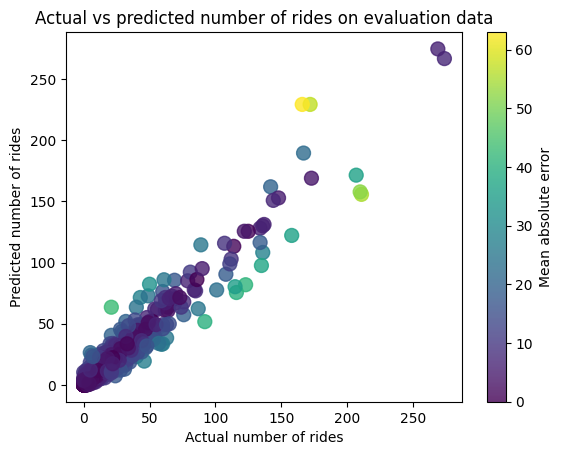

In [43]:
plt.scatter(eval_df.num_of_rides, eval_df.prediction, c=eval_df.mae, cmap='viridis', s=100, alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Mean absolute error')
plt.title('Actual vs predicted number of rides on evaluation data')
plt.xlabel('Actual number of rides')
plt.ylabel('Predicted number of rides')

In [44]:
location_df = rides_df.groupby('h3index_small').agg({'start_lat': 'mean', 'start_lon':'mean'}).reset_index()
location_df

,h3index_small,start_lat,start_lon
0,891f2506107ffff,57.690682,11.907544
1,891f2506123ffff,57.689369,11.913554
2,891f2506127ffff,57.689381,11.918697
3,891f250612bffff,57.686695,11.911921
4,891f250612fffff,57.687183,11.916678
...,...,...,...
321,891f25a9eafffff,57.715892,12.005066
322,891f25a9eb3ffff,57.719611,12.002698
323,891f25a9eb7ffff,57.720376,12.005948
324,891f25a9ebbffff,57.716997,11.999505


In [45]:
mape_per_area_df = eval_df.groupby('h3index_small').agg({'mae':'mean', 'percent_error':'mean', 'num_of_rides': 'mean'}).reset_index()
mape_per_area_df = pd.merge(mape_per_area_df,location_df, how='left', on='h3index_small')
mape_per_area_df

,h3index_small,mae,percent_error,num_of_rides,start_lat,start_lon
0,891f2506107ffff,1.800000,140.000000,1.000000,57.690682,11.907544
1,891f2506123ffff,3.000000,23.611111,12.500000,57.689369,11.913554
2,891f2506127ffff,3.000000,29.870130,9.000000,57.689381,11.918697
3,891f250612bffff,1.250000,39.583333,3.250000,57.686695,11.911921
4,891f250612fffff,3.000000,42.857143,7.000000,57.687183,11.916678
...,...,...,...,...,...,...
309,891f25a9eabffff,10.666667,19.431761,61.333333,57.715111,12.001382
310,891f25a9eafffff,4.750000,34.722222,17.000000,57.715892,12.005066
311,891f25a9eb3ffff,2.125000,81.994048,3.375000,57.719611,12.002698
312,891f25a9eb7ffff,6.250000,58.899711,13.750000,57.720376,12.005948


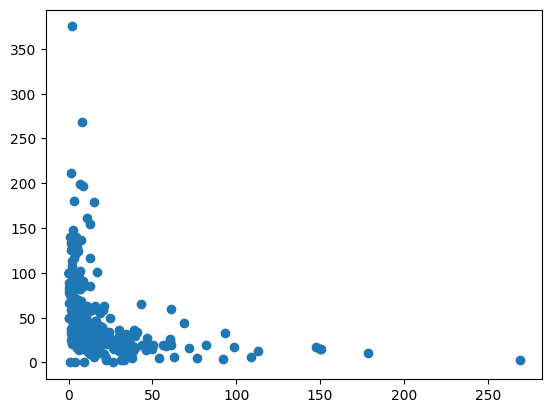

In [46]:
plt.scatter(mape_per_area_df.num_of_rides, mape_per_area_df.percent_error)

Text(0, 0.5, 'Residual')

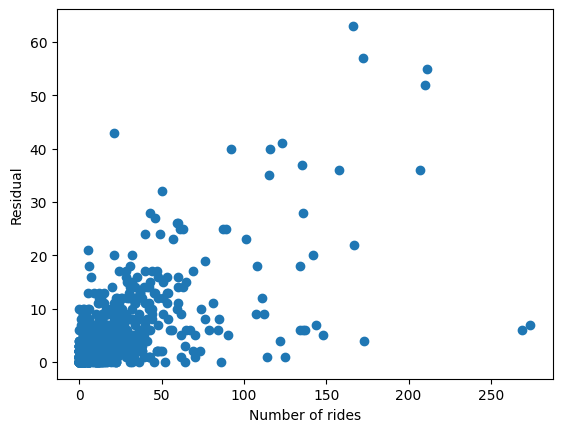

In [47]:
plt.scatter(eval_df.num_of_rides, eval_df.mae)
plt.xlabel('Number of rides')
plt.ylabel('Residual')

Text(0, 0.5, 'Residual')

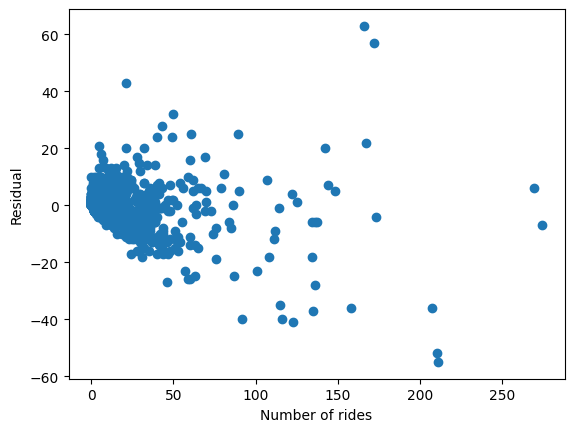

In [52]:
plt.scatter(eval_df.num_of_rides, eval_df.residuals)
plt.xlabel('Number of rides')
plt.ylabel('Residual')

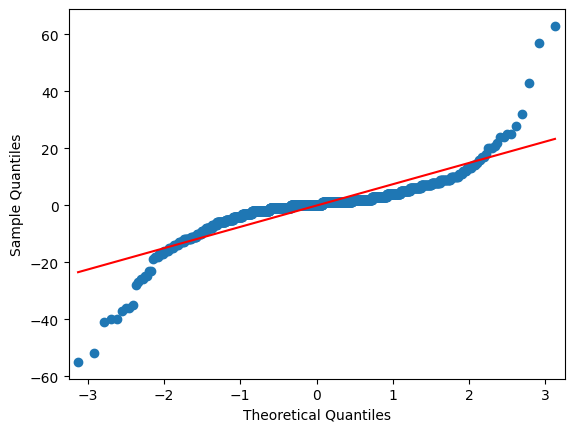

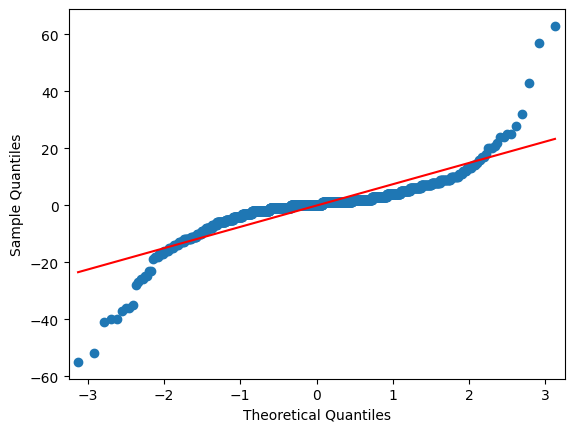

In [29]:
import statsmodels.api as sm

sm.qqplot(eval_df.residuals, line='s') 

Text(0.5, 1.0, 'Mean absolute error per h3index_small area')

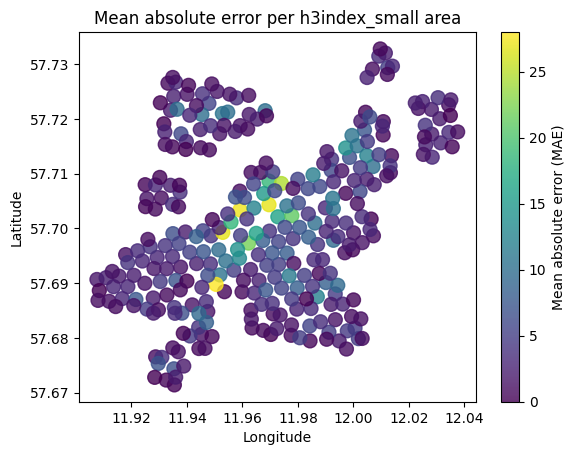

In [51]:

latitude = np.array(mape_per_area_df.start_lat)
longitude = np.array(mape_per_area_df.start_lon)
mae = np.array(mape_per_area_df.mae)

plt.scatter(longitude, latitude, c=mae, cmap='viridis', s=100, alpha=0.8)

# Adding colorbar for better interpretation of numbers
cbar = plt.colorbar()
cbar.set_label('Mean absolute error (MAE)')

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean absolute error per h3index_small area')


<Axes: >

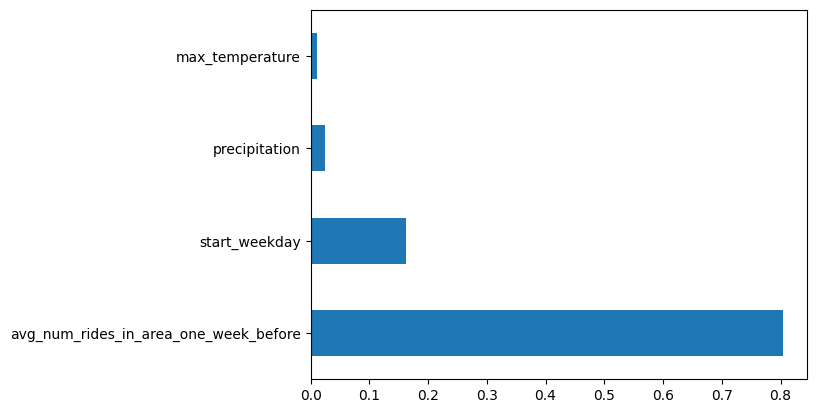

In [33]:
feature_importances = pd.Series(model.feature_importances_, index=list(X.columns))
feature_importances.nlargest(10).plot(kind='barh')